In [12]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from modules.feature_extractor import SIFT

# Load dataset
with open('office_dataset_aruco/ground_truth_poses.json', 'r') as f:
    ground_truth = json.load(f)

camera_intrinsics = ground_truth["camera_intrinsics"]
K = np.array([[camera_intrinsics["fx"], 0, camera_intrinsics["cx"]],
              [0, camera_intrinsics["fy"], camera_intrinsics["cy"]],
              [0, 0, 1]], dtype=np.float32)

images_path = "office_dataset_aruco/left"

def load_image(frame_num):
    filename = f"frame_{frame_num:04d}.png"
    filepath = os.path.join(images_path, filename)
    img = cv2.imread(filepath)
    if img is None:
        print(f"Error: Could not load {filepath}")
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load frames 1, 2, 3
frames = {}
for frame_num in [1, 2, 3]:
    img = load_image(frame_num)
    if img is not None:
        frames[frame_num] = img
        print(f"Loaded frame {frame_num}: {img.shape}")

# Extract features
extractor = SIFT(n_features=2000)
features = {}

for frame_num, img in frames.items():
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, desc = extractor.detect_and_compute(gray)
    features[frame_num] = {
        'keypoints': kp,
        'descriptors': desc,
        'image': img
    }
    print(f"Frame {frame_num}: {len(kp)} keypoints")

Loaded frame 1: (960, 1280, 3)
Loaded frame 2: (960, 1280, 3)
Loaded frame 3: (960, 1280, 3)
Frame 1: 1601 keypoints
Frame 2: 1876 keypoints
Frame 3: 2003 keypoints


In [13]:
# Match frame 1 and frame 2
desc1 = features[1]['descriptors']
desc2 = features[2]['descriptors']

matches = extractor.match_features(desc1, desc2)

# Store everything we need about each match
match_data = []
for match in matches:
    kp_idx_1 = match.queryIdx  # Index into frame 1 keypoints
    kp_idx_2 = match.trainIdx  # Index into frame 2 keypoints
    
    pt_1 = features[1]['keypoints'][kp_idx_1].pt
    pt_2 = features[2]['keypoints'][kp_idx_2].pt
    
    match_data.append({
        'kp_idx_1': kp_idx_1,
        'kp_idx_2': kp_idx_2,
        'pt_1': np.array(pt_1),
        'pt_2': np.array(pt_2),
        'distance': match.distance
    })

print(f"Found {len(match_data)} matches between frames 1 and 2")
print(f"Sample match: frame1 kp_idx={match_data[0]['kp_idx_1']}, frame2 kp_idx={match_data[0]['kp_idx_2']}")

Found 331 matches between frames 1 and 2
Sample match: frame1 kp_idx=12, frame2 kp_idx=69


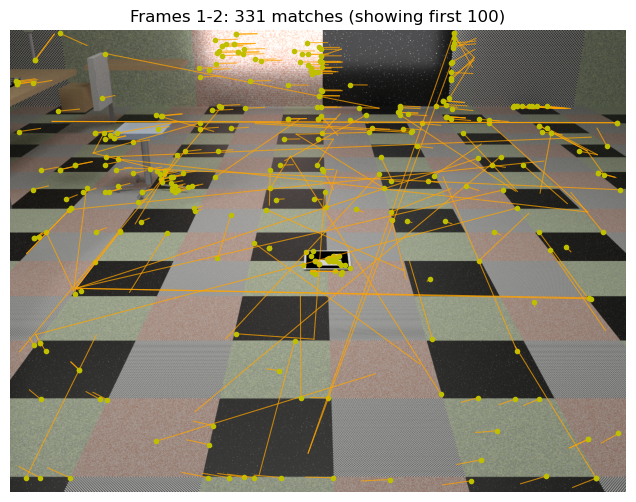

Total matches: 331


In [14]:
# Visualize matches between frames 1 and 2
plt.figure(figsize=(12, 6))
plt.imshow(features[1]['image'])

for match in match_data:  # Show first 100 matches to avoid clutter
    pt1 = match['pt_1']
    pt2 = match['pt_2']
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='orange', linestyle='-', linewidth=0.8, alpha=0.7)
    plt.plot(pt1[0], pt1[1], 'yo', markersize=3)

plt.title(f"Frames 1-2: {len(match_data)} matches (showing first 100)")
plt.axis('off')
plt.show()

print(f"Total matches: {len(match_data)}")

After distance filtering: 310 matches (from 331)


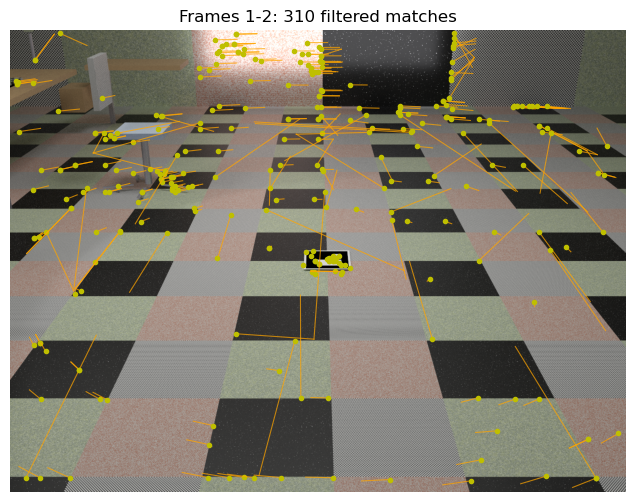

In [15]:
# Apply distance filtering
max_distance = 350
filtered_matches = []

for match in match_data:
    pt1 = match['pt_1']
    pt2 = match['pt_2']
    distance = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
    
    if distance <= max_distance:
        filtered_matches.append(match)

print(f"After distance filtering: {len(filtered_matches)} matches (from {len(match_data)})")

# Visualize filtered matches
plt.figure(figsize=(12, 6))
plt.imshow(features[1]['image'])

for match in filtered_matches:
    pt1 = match['pt_1']
    pt2 = match['pt_2']
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='orange', linestyle='-', linewidth=0.8, alpha=0.7)
    plt.plot(pt1[0], pt1[1], 'yo', markersize=3)

plt.title(f"Frames 1-2: {len(filtered_matches)} filtered matches")
plt.axis('off')
plt.show()

In [16]:
def fundamentalMatrix(input_points, correspondence_points):
    A = []
    for (x, y, _), (xc, yc, _) in zip(input_points, correspondence_points):
        A.append([x*xc, y*xc, xc, x*yc, y*yc, yc, x, y, 1])
    A = np.array(A)
    
    # Perform SVD
    U, e, V = np.linalg.svd(A)
    f = V[-1, :]
    
    F = f.reshape(3, 3)
    
    # Enforce rank 2 constraint on F
    U_f, S_f, V_f = np.linalg.svd(F)
    S_f[-1] = 0
    F = U_f @ np.diag(S_f) @ V_f
    
    return F/F[2,2]

def sampsonDistance(F, pts1, pts2):
    numerator = pts2.T @ F @ pts1
    denominator = (F @ pts1)[0]**2 + (F @ pts1)[1]**2 + (F.T @ pts2)[0]**2 + (F.T @ pts2)[1]**2
    return (numerator**2) / denominator

Best F:
[[ 9.60434443e-07  2.06728269e-05 -1.10770641e-02]
 [-2.05779815e-05  2.62535326e-06  1.53829075e-02]
 [ 9.81945743e-03 -1.79958146e-02  1.00000000e+00]]
Number of inliers: 247


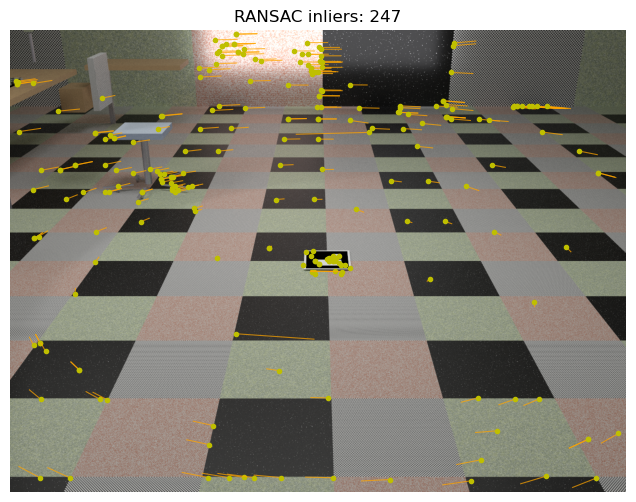

In [17]:
import random

# Prepare homogeneous coordinates from filtered matches
pts1 = np.array([match['pt_1'] for match in filtered_matches])
pts2 = np.array([match['pt_2'] for match in filtered_matches])

pts1_homog = np.column_stack([pts1, np.ones(len(pts1))])
pts2_homog = np.column_stack([pts2, np.ones(len(pts2))])

# RANSAC parameters
iterations = 800
best_inliers = []
best_F = None
threshold = 20

for iteration in range(iterations):
    try:
        # Step 1.1: random sample of 8 points
        indices = random.sample(range(len(pts1_homog)), 8)
        sample1 = pts1_homog[indices]
        sample2 = pts2_homog[indices]
        
        # Step 1.2: estimate fundamental matrix
        F = fundamentalMatrix(sample1, sample2)
        
        # Step 1.3: compute Sampson distance for all points
        inliers = []
        for i, (p1, p2) in enumerate(zip(pts1_homog, pts2_homog)):
            d = sampsonDistance(F, p1, p2)
            if d < threshold:
                inliers.append((p1, p2, i))  # Store index too
        
        # Step 2: update best consensus set
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_F = F
    except:
        continue

# Step 3: re-estimate F using all inliers
if best_inliers:
    inlier_pts1 = np.array([p1 for p1, p2, idx in best_inliers])
    inlier_pts2 = np.array([p2 for p1, p2, idx in best_inliers])
    best_F = fundamentalMatrix(inlier_pts1, inlier_pts2)

print(f"Best F:\n{best_F}")
print(f"Number of inliers: {len(best_inliers)}")

# Visualize
plt.figure(figsize=(12, 6))
plt.imshow(features[1]['image'])

for (p1, p2, idx) in best_inliers:
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    plt.plot([x1, x2], [y1, y2], color='orange', linestyle='-', linewidth=0.8, alpha=0.7)
    plt.plot(x1, y1, 'yo', markersize=3)

plt.title(f"RANSAC inliers: {len(best_inliers)}")
plt.axis('off')
plt.show()

In [18]:
# Build projection matrices from ground truth
def build_projection_matrix(frame_idx, K):
    pose = ground_truth['poses'][frame_idx]['left_camera']
    R = np.array(pose['rotation_matrix'])
    t = np.array(pose['translation']).reshape(-1, 1)
    
    # Convert camera-to-world to world-to-camera
    R_wc = R.T
    t_wc = -R_wc @ t
    
    Rt = np.hstack([R_wc, t_wc])
    return K @ Rt

# Frame 1 is index 0, frame 2 is index 1, frame 3 is index 2
P1 = build_projection_matrix(0, K)
P2 = build_projection_matrix(1, K)

print("P1 shape:", P1.shape)
print("P2 shape:", P2.shape)

P1 shape: (3, 4)
P2 shape: (3, 4)


In [19]:
# Extract 2D points from RANSAC inliers
inlier_pts1_2d = np.array([p1[:2] for p1, p2, idx in best_inliers])
inlier_pts2_2d = np.array([p2[:2] for p1, p2, idx in best_inliers])

# Triangulate
points_4d = cv2.triangulatePoints(P1, P2, inlier_pts1_2d.T, inlier_pts2_2d.T)
points_3d = points_4d[:3] / points_4d[3]
points_3d = points_3d.T

print(f"Triangulated {len(points_3d)} 3D points")
print(f"Sample 3D point: {points_3d[0]}")
print(f"3D points range: min={points_3d.min(axis=0)}, max={points_3d.max(axis=0)}")

Triangulated 247 3D points
Sample 3D point: [1.72073598 1.02310326 1.48949189]
3D points range: min=[-107.85918473   -9.2298529   -79.63612188], max=[114.807158    63.04439919 100.609186  ]
